In [1]:
import pandas as pd
import numpy as np

import os
import psycopg2
import dotenv

import matplotlib.pyplot as plt
import seaborn as sns

dotenv.load_dotenv(dotenv.find_dotenv())

pd.set_option('display.float_format', lambda x: '%.2f' % x)

ModuleNotFoundError: No module named 'pandas'

In [2]:
# Cria conexão com o banco de dados
def conexao():
    con = psycopg2.connect(
        user=os.getenv("POSTGRES_USER"),
        password=os.getenv("POSTGRES_PASSWORD"),
        database=os.getenv("POSTGRES_DB"),
        host="localhost",
    )
    
    return con

# Cria função para selecionar os dados
def se_dados(query):
    vcon = conexao()
    c = vcon.cursor()
    c.execute(query)
    rows = c.fetchall()
    vcon.commit()
    vcon.close()
    return rows

In [5]:
ticker = 'ENAT3'

# Cria query 
query = f" SELECT DISTINCT data_ult_cotacao, papel, cotacao, pl, ev_ebitda, vpa \
            FROM dados \
                WHERE papel = '{ticker}' \
                        ORDER BY 2 "
result = se_dados(query)

# Cria DataFrame 
df_rl = pd.DataFrame(result)

df_rl.rename(columns={0:'Data', 
    1:'Papel', 
    2:'Cotação',
    3:'PL',
    4:'Ev_Ebitda',
    5:'VPA' }, inplace=True)

df_rl.set_index('Data', inplace = True)

df_rl.head()

,Papel,Cotação,PL,Ev_Ebitda,VPA
Data,,,,,
2021-11-19,ENAT3,"R$ 12,65",4.25,1.82,13.04
2021-11-22,ENAT3,"R$ 12,68",4.26,1.83,13.04
2021-11-23,ENAT3,"R$ 12,80",4.30,1.86,13.04
2021-11-24,ENAT3,"R$ 13,11",4.40,1.94,13.04
2021-11-25,ENAT3,"R$ 13,07",4.39,1.93,13.04


In [6]:
print(df_rl.dtypes)

df_rl['Cotação'] = df_rl['Cotação'].str.replace('R',' ', regex=True) 
df_rl['Cotação'] = df_rl['Cotação'].str.replace('$',' ', regex=True) 
df_rl['Cotação'] = df_rl['Cotação'].str.replace(',','.') # Alterando de virgula para ponto
df_rl['Cotação'] = df_rl['Cotação'].apply(pd.to_numeric)

print('-------')
print(df_rl.dtypes)
df_rl

Papel         object
Cotação       object
PL           float64
Ev_Ebitda    float64
VPA          float64
dtype: object
-------
Papel         object
Cotação      float64
PL           float64
Ev_Ebitda    float64
VPA          float64
dtype: object


,Papel,Cotação,PL,Ev_Ebitda,VPA
Data,,,,,
2021-11-19,ENAT3,12.65,4.25,1.82,13.04
2021-11-22,ENAT3,12.68,4.26,1.83,13.04
2021-11-23,ENAT3,12.80,4.30,1.86,13.04
2021-11-24,ENAT3,13.11,4.40,1.94,13.04
2021-11-25,ENAT3,13.07,4.39,1.93,13.04
...,...,...,...,...,...
2022-06-28,ENAT3,18.00,3.51,1.85,14.99
2022-06-29,ENAT3,18.05,3.52,1.86,14.99
2022-06-30,ENAT3,17.57,3.43,1.78,14.99


Text(0, 0.5, 'Ev_Ebitda')

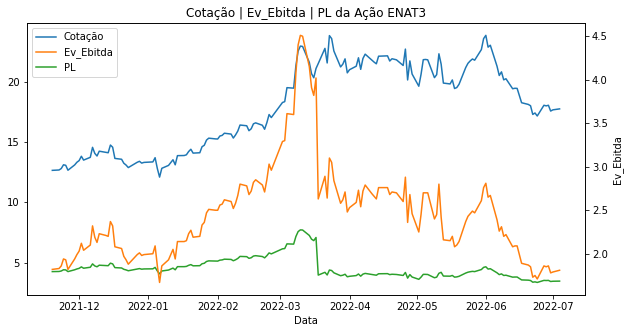

In [7]:
df_rl[['Cotação','Ev_Ebitda','PL']].plot(secondary_y='Ev_Ebitda',mark_right=False,figsize=(10,5));
plt.title(f'Cotação | Ev_Ebitda | PL da Ação {ticker}');
plt.ylabel('Ev_Ebitda')

# IFR

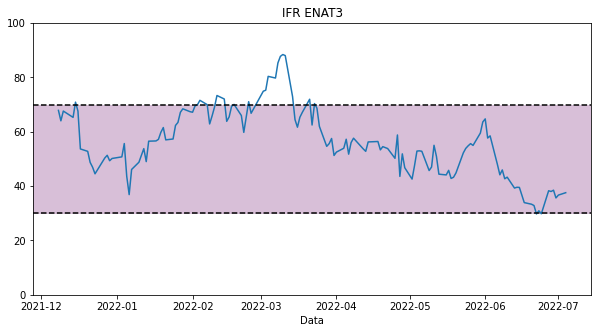

In [27]:
df_ifr = df_rl.copy()
df_ifr.drop(['PL','Ev_Ebitda','VPA'], axis=1, inplace=True)

df_ifr['Variation'] = df_ifr['Cotação'].diff()

df_ifr['Gain'] = np.where(df_ifr['Variation'] > 0, df_ifr['Variation'], 0) 
df_ifr['Loss'] = np.where(df_ifr['Variation'] < 0, df_ifr['Variation'], 0)

n = 14 # define window interval
simple_avg_gain = df_ifr['Gain'].rolling(n).mean()
simple_avg_loss = df_ifr['Loss'].abs().rolling(n).mean()

classic_avg_gain = simple_avg_gain.copy()
classic_avg_loss = simple_avg_loss.copy()

# iterate over the new series but only change values after the nth element
for i in range(n, len(classic_avg_gain)):
    classic_avg_gain[i] = (classic_avg_gain[i - 1] * (n - 1) + df_ifr['Gain'].iloc[i]) / n
    classic_avg_loss[i] = (classic_avg_loss[i - 1] * (n - 1) + df_ifr['Loss'].abs().iloc[i]) / n

df_ifr['Simple RS'] = simple_avg_gain / simple_avg_loss
df_ifr['Classic RS'] = classic_avg_gain / classic_avg_loss    

df_ifr['Simple RSI'] = 100 - (100 / (1 + df_ifr['Simple RS']))
df_ifr['Classic RSI'] = 100 - (100 / (1 + df_ifr['Classic RS']))

plt.figure(figsize=(10,5))
plt.title(f"IFR {ticker}")
df_ifr['Classic RSI'].plot()
plt.axhline(y=30, color='black', linestyle='--')
plt.axhline(y=70, color='black', linestyle='--')
plt.axhspan(30, 70, color='thistle')
plt.ylim(0, 100)
plt.show()

In [2]:
import yfinance as yf
from datetime import date

inicio = "2010-01-01"
fim = date.today()

df = yf.download(
        f"ITSA4.SA",
        start=inicio,
        end=fim,
        progress=False,
        threads=False,
)

In [3]:
df["ret"] = round((df["Adj Close"].pct_change()) * 100, 2)
df["Returns"] = df["Adj Close"].pct_change(1)

In [4]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,ret,Returns
Date,,,,,,,,
2010-01-04,5.677845,5.901908,5.677845,5.897140,3.082911,11093298.0,NaN,NaN
2010-01-05,5.930511,5.940046,5.820864,5.878071,3.072940,10565325.0,-0.32,-0.003234
2010-01-06,5.859002,5.906675,5.797027,5.806562,3.035557,10640630.0,-1.22,-0.012165
2010-01-07,5.792260,5.811329,5.725518,5.773191,3.018111,8893307.0,-0.57,-0.005747
2010-01-08,5.754122,5.792260,5.701681,5.730285,2.995681,9374713.0,-0.74,-0.007432
